In [1]:
from __future__ import print_function

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.oauth2.credentials import Credentials
from azure.storage.blob import BlobServiceClient

import pandas as pd
import os.path
import json
pd.set_option('display.max_rows', 500)

In [2]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']
root_dir =  os.path.abspath(os.getcwd()+"..\\..\\..\\..\\..\\")
tmp_dir = root_dir + "\\.tmp"
cred_dir = root_dir + "\\.cred"
data_dir = root_dir + "\\data\\"
site_summary_filename = data_dir + "hourly-site-summary.csv"

# Upload full halft hourly data from Google Drive to Azure Storage Blob

In [3]:
creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists(cred_dir+'\\token.json'):
    creds = Credentials.from_authorized_user_file(cred_dir+'\\token.json', SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            cred_dir+'\\credentials.json', SCOPES)
        creds = flow.run_local_server(port=8001)
    # Save the credentials for the next run
    with open(cred_dir+'\\token.json', 'w') as token:
        token.write(creds.to_json())

In [4]:
uploadToAzBlob = False

if uploadToAzBlob:
    azBlobCredFile = cred_dir+'\\azblobcred.json'
    if os.path.exists(azBlobCredFile):
        connect_str = ""
        with open(azBlobCredFile, "rb") as f:
            data = json.load(f)
            connect_str = data['connectionstr']
        blob_service_client = BlobServiceClient.from_connection_string(connect_str)
        container_name = "full-half-hourly-raw"
    else:
        print("ERROR: Missing Azure Storage Blob access tokens")
        
    if not (os.path.exists(tmp_dir)):
        os.mkdir(tmp_dir)

In [5]:
# Build the Drive API client

file_df = pd.DataFrame(columns = ["filename", "size", "country", "site_id"])

targetFolderName = 'data_full_half_hourly'
queryPageSize = 512
queryFields = "nextPageToken, files(id, name, size)"

try:
    service = build('drive', 'v3', credentials=creds)
    queryFolder = f"mimeType='application/vnd.google-apps.folder' and name='{targetFolderName}'"
    results = service.files().list(q=queryFolder, pageSize=10, fields="nextPageToken, files(id, name)").execute()
    folders = results.get('files', [])

    if not folders:
        print('No folder found.')
    else:
        folder = folders[0]
        print(f'{folder["name"]}:')
        folder_id = folder["id"]
        query = f"'{folder_id}' in parents and trashed = false"
        results = service.files().list(q=query, pageSize=queryPageSize, fields=queryFields).execute()
        files = results.get('files', [])
        token = results.get('nextPageToken', None)
        
        fileCount = 0
        
        if files:
            for file in files:
                fileName = file["name"]
                fileId   = file["id"]
                fileSize = file["size"]
                station = fileName.split('_')[-1].split(".")[0]
                country = station.split('-')[0]

                print(f'{fileCount+1:3}. {fileName} ({fileSize:>10})')
                
                fileMetadata = {
                    "filename": fileName,
                    "size": fileSize,
                    "country": country,
                    "site_id": station
                }
                file_df=file_df.append(fileMetadata, ignore_index=True)
                fileCount += 1
                
                if(uploadToAzBlob):
                    # Download file from Google Drive to local .tmp drive
                    local_filename = tmp_dir + "\\" + fileName
                    if not (os.path.exists(local_filename)):
                        file_data = service.files().get(fileId=fileId, fields='*').execute()
                        request = service.files().get_media(fileId=fileId)
                        file_handle = request.execute()
                        with open(local_filename, "wb") as f:
                            f.write(file_handle)
                
                    # Create a blob client using the local file name as the name for the blob
                    blob_client = blob_service_client.get_blob_client(container=container_name, blob=fileName)
                    with open(local_filename, "rb") as data:
                        blob_client.upload_blob(data)
                    print(f'\t\'{fileName}\' uploaded.')
                    
            ## Get Next Page Content (still buggy)
            #results = service.files().list(q=query, pageToken=token, fields=queryFields).execute()
            #files = results.get('files', [])
            #token = results.get('nextPageToken', None)
            
except HttpError as error:
    print(F'An error occurred: {error}')
    print(F'{error.resp.status}, {error.resp.reason}')
    
file_df.dropna(inplace=True)

data_full_half_hourly:
  1. data_full_half_hourly_raw_v0_1_CN-HaM.csv (  21307369)
  2. data_full_half_hourly_raw_v0_1_US-UMd.csv (  70907532)
  3. data_full_half_hourly_raw_v0_1_AU-Emr.csv (  17707070)
  4. data_full_half_hourly_raw_v0_1_DE-Kli.csv ( 115031759)
  5. data_full_half_hourly_raw_v0_1_BE-Lcr.csv (  11988594)
  6. data_full_half_hourly_raw_v0_1_DK-Gds.csv (   2632580)
  7. data_full_half_hourly_raw_v0_1_CZ-RAJ.csv (  65198714)
  8. data_full_half_hourly_raw_v0_1_IT-Isp.csv (  13549264)
  9. data_full_half_hourly_raw_v0_1_CA-Gro.csv (  74132529)
 10. data_full_half_hourly_raw_v0_1_US-Sta.csv (  19848993)
 11. data_full_half_hourly_raw_v0_1_US-KS1.csv (   5279188)
 12. data_full_half_hourly_raw_v0_1_IL-Yat.csv ( 139597716)
 13. data_full_half_hourly_raw_v0_1_FR-LGt.csv (  25211279)
 14. data_full_half_hourly_raw_v0_1_DK-Fou.csv (   4758374)
 15. data_full_half_hourly_raw_v0_1_IE-Cra.csv (   6989126)
 16. data_full_half_hourly_raw_v0_1_SE-Lnn.csv (  32921480)
 17. data_full_ha

168. data_full_half_hourly_raw_v0_1_AU-Wac.csv (  21467041)
169. data_full_half_hourly_raw_v0_1_IT-CA3.csv (  21222752)
170. data_full_half_hourly_raw_v0_1_AU-Cpr.csv (  31569504)
171. data_full_half_hourly_raw_v0_1_CN-Dan.csv (  12822510)
172. data_full_half_hourly_raw_v0_1_BE-Maa.csv (  33614924)
173. data_full_half_hourly_raw_v0_1_ES-Cnd.csv (  29195813)
174. data_full_half_hourly_raw_v0_1_FR-Fon.csv ( 109981671)
175. data_full_half_hourly_raw_v0_1_CZ-Lnz.csv (  42122333)
176. data_full_half_hourly_raw_v0_1_FI-Var.csv (  36525144)
177. data_full_half_hourly_raw_v0_1_ES-Abr.csv (  40330319)
178. data_full_half_hourly_raw_v0_1_IT-Lsn.csv (  36898890)
179. data_full_half_hourly_raw_v0_1_US-Ses.csv (  83255223)
180. data_full_half_hourly_raw_v0_1_IT-Ro2.csv (  71813758)
181. data_full_half_hourly_raw_v0_1_US-Tw1.csv (  33160645)
182. data_full_half_hourly_raw_v0_1_AU-Stp.csv (  43106187)
183. data_full_half_hourly_raw_v0_1_US-SRM.csv (  85092857)
184. data_full_half_hourly_raw_v0_1_IT-C

In [6]:
file_df.sort_values("filename")

,filename,size,country,site_id
32,data_full_half_hourly_raw_v0_1_AR-SLu.csv,9785735,AR,AR-SLu
221,data_full_half_hourly_raw_v0_1_AR-Vir.csv,14564015,AR,AR-Vir
28,data_full_half_hourly_raw_v0_1_AT-Neu.csv,80674656,AT,AT-Neu
124,data_full_half_hourly_raw_v0_1_AU-ASM.csv,32588027,AU,AU-ASM
130,data_full_half_hourly_raw_v0_1_AU-Ade.csv,10951700,AU,AU-Ade
169,data_full_half_hourly_raw_v0_1_AU-Cpr.csv,31569504,AU,AU-Cpr
228,data_full_half_hourly_raw_v0_1_AU-Cum.csv,16483369,AU,AU-Cum
86,data_full_half_hourly_raw_v0_1_AU-DaP.csv,39509404,AU,AU-DaP
64,data_full_half_hourly_raw_v0_1_AU-DaS.csv,49712116,AU,AU-DaS
218,data_full_half_hourly_raw_v0_1_AU-Dry.csv,34886065,AU,AU-Dry


In [7]:
file_df.shape

(276, 4)

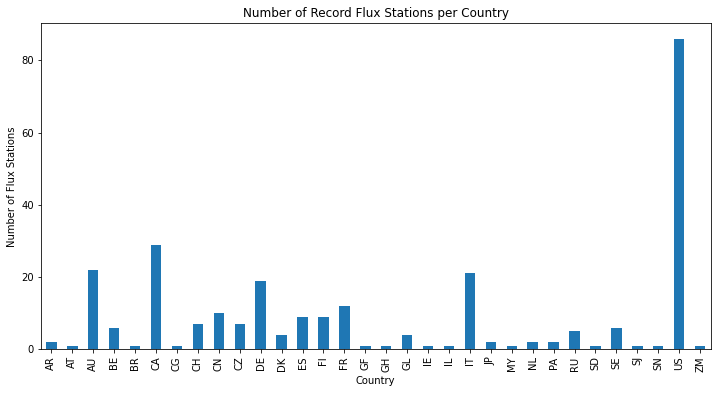

In [8]:
plot = file_df.groupby('country')['filename'].count()\
        .plot(kind='bar', figsize = (12,6),
              title = 'Number of Record Flux Stations per Country',
              xlabel = "Country",
              ylabel = "Number of Flux Stations")

In [9]:
# Save site_data checkpoint
file_df.to_csv(site_summary_filename, index_label="index");

# Sample Site Data EDA

In [31]:
# process sample file
local_filename = tmp_dir + "\\" + 'data_full_half_hourly_raw_v0_1_CA-SF2.csv'
df = pd.read_csv(local_filename)
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])
print(f"size:{df.shape}")
print(f"columns: {df.columns}")
df.head()

size:(21600, 64)
columns: Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F', 'TA_F_QC', 'TA_ERA',
       'SW_IN_POT', 'SW_IN_F', 'SW_IN_F_QC', 'SW_IN_ERA', 'LW_IN_F',
       'LW_IN_F_QC', 'LW_IN_ERA', 'VPD_F', 'VPD_F_QC', 'VPD_ERA', 'P_F',
       'P_F_QC', 'P_ERA', 'PA_F', 'PA_F_QC', 'PA_ERA', 'NETRAD', 'PPFD_IN',
       'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MDS_QC', 'LE_CORR',
       'H_F_MDS', 'H_F_MDS_QC', 'H_CORR', 'NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_CUT_REF', 'NEE_CUT_REF_QC', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF',
       'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'RECO_NT_VUT_REF',
       'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF', 'datetime',
       'year', 'month', 'day', 'hour', 'SITE_ID', 'date', 'NEE_VUT_REF_qa',
       'SW_DIF', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'koppen'],
      dtype='object')


,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200304120000,200304120030,2.9,0,1.459,0.0,0.0,0,0.0,285.14,...,0.067344,0.0662,0.1612,0.0455,0.0537,0.2068,0.1985,0.1185,ENF,Cold
1,200304120030,200304120100,2.2,0,1.098,0.0,0.0,0,0.0,285.14,...,0.067344,0.0662,0.1612,0.0455,0.0537,0.2068,0.1985,0.1185,ENF,Cold
2,200304120100,200304120130,1.8,0,0.737,0.0,0.0,0,0.0,285.14,...,0.067344,0.0662,0.1612,0.0455,0.0537,0.2068,0.1985,0.1185,ENF,Cold
3,200304120130,200304120200,1.7,0,0.377,0.0,0.0,0,0.0,285.14,...,0.067344,0.0662,0.1612,0.0455,0.0537,0.2068,0.1985,0.1185,ENF,Cold
4,200304120200,200304120230,1.2,0,0.016,0.0,0.0,0,0.0,285.14,...,0.067344,0.0662,0.1612,0.0455,0.0537,0.2068,0.1985,0.1185,ENF,Cold


In [11]:
df.tail()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
196747,201412312130,201412312200,23.73,0,25.108,0.0,0.0,0,0.0,399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical
196748,201412312200,201412312230,23.58,0,25.121,0.0,0.0,0,0.0,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical
196749,201412312230,201412312300,23.23,0,25.135,0.0,0.0,0,0.0,396.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical
196750,201412312300,201412312330,23.38,0,25.149,0.0,0.0,0,0.0,393.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical
196751,201412312330,201501010000,23.39,0,25.163,0.0,0.0,0,0.0,396.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical


In [12]:
df.isna().sum()

TIMESTAMP_START         0
TIMESTAMP_END           0
TA_F                    0
TA_F_QC                 0
TA_ERA                  0
SW_IN_POT               0
SW_IN_F                 0
SW_IN_F_QC              0
SW_IN_ERA               0
LW_IN_F                 0
LW_IN_F_QC              0
LW_IN_ERA               0
VPD_F                   0
VPD_F_QC                0
VPD_ERA                 0
P_F                     0
P_F_QC                  0
P_ERA                   0
PA_F                    0
PA_F_QC                 0
PA_ERA                  0
NETRAD              65309
PPFD_IN            196752
G_F_MDS             21646
G_F_MDS_QC          21646
LE_F_MDS                0
LE_F_MDS_QC             0
LE_CORR             14482
H_F_MDS                 0
H_F_MDS_QC              0
H_CORR              14482
NEE_VUT_REF             0
NEE_VUT_REF_QC          0
NEE_CUT_REF             0
NEE_CUT_REF_QC          0
GPP_NT_VUT_REF          0
GPP_DT_VUT_REF          0
GPP_NT_CUT_REF          0
GPP_DT_CUT_R

In [13]:
df.describe(include=['object'])

,SITE_ID,IGBP,koppen
count,196752,196752,196752
unique,1,1,1
top,AU-How,WSA,Tropical
freq,196752,196752,196752


In [32]:
df[['date', 'datetime']].describe(datetime_is_numeric=True)

,date,datetime
count,21600,21600
mean,2004-06-07 04:44:48,2004-06-07 16:29:47.999999872
min,2003-04-12 00:00:00,2003-04-12 00:00:00
25%,2003-08-02 00:00:00,2003-08-02 11:52:30
50%,2004-06-14 12:00:00,2004-06-14 23:45:00
75%,2005-04-29 00:00:00,2005-04-29 11:37:30
max,2005-09-17 00:00:00,2005-09-17 23:30:00


In [15]:
df['date'].unique().shape[0]

4099

## Other Numerical Describes

In [16]:
df[['TA_F', 'TA_F_QC', 'TA_ERA',
    'SW_IN_POT', 'SW_IN_F', 'SW_IN_F_QC', 'SW_IN_ERA', 'SW_DIF',
    'LW_IN_F','LW_IN_F_QC', 'LW_IN_ERA',
    'VPD_F', 'VPD_F_QC', 'VPD_ERA',
    'P_F', 'P_F_QC', 'P_ERA',
    'PA_F', 'PA_F_QC', 'PA_ERA',]].describe()

,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,SW_DIF,LW_IN_F,LW_IN_F_QC,LW_IN_ERA,VPD_F,VPD_F_QC,VPD_ERA,P_F,P_F_QC,P_ERA,PA_F,PA_F_QC,PA_ERA
count,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,0.0,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000
mean,26.694168,0.071217,26.658354,407.687000,235.196930,0.007182,231.486650,NaN,394.100448,0.076848,394.672164,12.621632,0.087105,12.597801,0.089756,0.156959,0.088875,100.385132,0.135206,100.392020
std,3.994076,0.263126,3.445661,498.317074,321.016791,0.101947,301.737525,NaN,35.804798,0.347040,30.669024,9.490461,0.290966,7.581553,0.902229,0.537851,0.441786,0.416554,0.502128,0.321149
min,9.480000,0.000000,14.396000,0.000000,0.000000,0.000000,0.000000,NaN,258.000000,0.000000,291.287000,0.000000,0.000000,2.159000,0.000000,0.000000,0.000000,98.800000,0.000000,98.962000
25%,24.330000,0.000000,24.666000,0.000000,0.000000,0.000000,0.000000,NaN,372.000000,0.000000,375.591000,4.837000,0.000000,6.228000,0.000000,0.000000,0.000000,100.110000,0.000000,100.170000
50%,26.490000,0.000000,26.407000,15.717850,5.000000,0.000000,0.000000,NaN,399.000000,0.000000,401.997000,9.940000,0.000000,11.004000,0.000000,0.000000,0.000000,100.427000,0.000000,100.400000
75%,29.610000,0.000000,28.962250,899.082000,471.000000,0.000000,469.282000,NaN,422.000000,0.000000,416.703000,18.767250,0.000000,17.754000,0.000000,0.000000,0.000000,100.690000,0.000000,100.627000
max,38.850000,2.000000,38.001000,1410.020000,1282.000000,2.000000,997.698000,NaN,487.000000,2.000000,477.697000,55.529000,2.000000,45.156000,48.240000,2.000000,24.603000,101.630000,2.000000,101.456000


In [17]:
df[['NETRAD', 'PPFD_IN',
    'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MDS_QC',
    'LE_CORR', 'H_F_MDS', 'H_F_MDS_QC', 'H_CORR']].describe()

,NETRAD,PPFD_IN,G_F_MDS,G_F_MDS_QC,LE_F_MDS,LE_F_MDS_QC,LE_CORR,H_F_MDS,H_F_MDS_QC,H_CORR
count,131443.000000,0.0,175106.000000,175106.000000,196752.000000,196752.000000,182270.000000,196752.000000,196752.000000,182270.000000
mean,140.404251,NaN,0.443448,0.139327,87.299218,0.208023,103.638020,41.598622,0.196816,49.925810
std,261.223111,NaN,48.049743,0.514321,126.063209,0.422148,148.147482,90.112805,0.414246,111.080769
min,-149.000000,NaN,-298.000000,0.000000,-98.000000,0.000000,-136.090000,-100.000000,0.000000,-146.267000
25%,-50.000000,NaN,-30.000000,0.000000,3.000000,0.000000,3.214997,-11.000000,0.000000,-12.639375
50%,-12.000000,NaN,-19.000000,0.000000,18.000000,0.000000,20.836550,-2.000000,0.000000,-2.476100
75%,330.000000,NaN,23.000000,0.000000,142.000000,0.000000,172.070750,72.000000,0.000000,81.307425
max,1061.000000,NaN,277.000000,3.000000,987.000000,3.000000,1134.450000,689.000000,3.000000,881.107000


In [18]:
df[['NEE_VUT_REF', 'NEE_VUT_REF_QC', 'NEE_VUT_REF_qa', 'NEE_CUT_REF', 'NEE_CUT_REF_QC',
    'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF',
    'RECO_NT_VUT_REF', 'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF']].describe()

,NEE_VUT_REF,NEE_VUT_REF_QC,NEE_VUT_REF_qa,NEE_CUT_REF,NEE_CUT_REF_QC,GPP_NT_VUT_REF,GPP_DT_VUT_REF,GPP_NT_CUT_REF,GPP_DT_CUT_REF,RECO_NT_VUT_REF,RECO_DT_VUT_REF,RECO_NT_CUT_REF,RECO_DT_CUT_REF
count,196752.000000,196752.000000,190037.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000,196752.000000
mean,-1.811464,0.620990,-1.847540,-1.806947,0.610347,5.172235,5.328654,5.146825,5.341395,3.312821,3.634318,3.339879,3.669721
std,7.132144,0.555007,7.176989,7.128363,0.550495,7.651987,7.371064,7.646270,7.371955,1.677114,2.211639,1.659124,2.189175
min,-70.849400,0.000000,-70.849400,-70.849400,0.000000,-44.816800,0.000000,-44.870600,0.000000,0.000001,0.008683,0.000001,0.005457
25%,-6.071190,0.000000,-6.166110,-6.055000,0.000000,-0.071856,0.000000,-0.085284,0.000000,1.881918,1.817550,1.937698,1.857347
50%,1.166460,1.000000,1.172930,1.139630,1.000000,1.196885,0.277314,1.161280,0.275635,3.176455,3.302070,3.223770,3.360670
75%,3.256440,1.000000,3.278570,3.298200,1.000000,9.193245,9.267473,9.147993,9.329730,4.573050,5.102493,4.584560,5.144703
max,47.855800,3.000000,47.855800,47.855800,3.000000,73.287300,38.941900,73.407100,39.264400,10.855900,18.150100,10.651900,14.884700


In [19]:
df[['EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']].describe()

,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7
count,164208.000000,164736.000000,164736.000000,164736.000000,164736.000000,164208.000000,164736.000000,164112.000000,153408.000000,164736.000000
mean,0.337774,0.584060,0.155096,0.066868,0.260080,0.031743,0.062743,0.301725,0.219381,0.115060
std,0.080180,0.092634,0.047530,0.012252,0.043535,0.005862,0.008776,0.034913,0.033917,0.034166
min,0.132852,0.322202,0.047203,0.026400,0.145300,0.013200,0.035600,0.198300,0.148800,0.053300
25%,0.285833,0.519055,0.125043,0.057300,0.234600,0.027900,0.055900,0.282200,0.193975,0.088500
50%,0.323534,0.582241,0.144966,0.065400,0.253000,0.030800,0.060600,0.297500,0.212550,0.108400
75%,0.397993,0.665032,0.186081,0.077000,0.286225,0.035700,0.068800,0.322300,0.243000,0.137800
max,0.568659,0.783528,0.301332,0.103400,0.438800,0.059500,0.110100,0.448200,0.330500,0.213500


# Get Site Metadata

In [20]:
# enable parallelism: https://stackoverflow.com/a/59385935
import asyncio
import nest_asyncio

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

In [21]:
summary_df = pd.read_csv(site_summary_filename, index_col='index')
summary_df.head()

,filename,size,country,site_id
index,,,,
0,data_full_half_hourly_raw_v0_1_CN-HaM.csv,21307369,CN,CN-HaM
1,data_full_half_hourly_raw_v0_1_US-UMd.csv,70907532,US,US-UMd
2,data_full_half_hourly_raw_v0_1_AU-Emr.csv,17707070,AU,AU-Emr
3,data_full_half_hourly_raw_v0_1_DE-Kli.csv,115031759,DE,DE-Kli
4,data_full_half_hourly_raw_v0_1_BE-Lcr.csv,11988594,BE,BE-Lcr


In [22]:
# Add columns
summary_df['record_count'] = ''
summary_df['site_IGBP'] = ''
summary_df['site_koppen'] = ''
summary_df['start_time'] = ''
summary_df['end_time'] = ''
summary_df['recorded_day_count'] = ''
summary_df['recorded_day_percentage'] = ''

In [23]:
@background
def update_summary_record(index, r, summary_df):
    local_filename = tmp_dir + "\\" + r.filename
    site_df = pd.read_csv(local_filename)
    site_df['datetime'] = pd.to_datetime(site_df['datetime'])
    
    if(site_df.loc[0].SITE_ID != summary_df.loc[index].site_id):
          print(f'  ERROR: SiteID mismatch: {site_df.loc[0].SITE_ID} vs {summary_df.loc[index].site_id}.')
    
    recorded_days = site_df['date'].unique().shape[0]
    delta = site_df['datetime'].max()-site_df['datetime'].min()
    recorded_days_percent = round(recorded_days/(delta.days+1),5)
    print(f'{index:3}. {site_df.loc[0].SITE_ID}({delta}): {recorded_days}/{delta.days+1} = {recorded_days_percent}')
    
    summary_df.loc[index,'record_count'] = site_df.shape[0]
    summary_df.loc[index,'site_IGBP']    = site_df.loc[0].IGBP
    summary_df.loc[index,'site_koppen']  = site_df.loc[0].koppen
    summary_df.loc[index,'start_time']   = site_df['datetime'].min()
    summary_df.loc[index,'end_time']     = site_df['datetime'].max()
    summary_df.loc[index,'recorded_day_count'] = recorded_days
    summary_df.loc[index,'recorded_day_percentage'] = recorded_days_percent
    print(f'{index:3}. Got {site_df.loc[0].SITE_ID} info from {r.filename}.')

In [24]:
nest_asyncio.apply()
loop = asyncio.get_event_loop()
looper = asyncio.gather(*[update_summary_record(index, r, summary_df) for index, r in summary_df.iterrows()])         # Run the loop                
results = loop.run_until_complete(looper)
print(f'Site summary update completed.')

  5. DK-Gds(158 days 23:30:00): 159/159 = 1.0
  5. Got DK-Gds info from data_full_half_hourly_raw_v0_1_DK-Gds.csv.
 10. US-KS1(299 days 23:30:00): 276/300 = 0.92
 10. Got US-KS1 info from data_full_half_hourly_raw_v0_1_US-KS1.csv.
 13. DK-Fou(255 days 23:30:00): 241/256 = 0.94141
 13. Got DK-Fou info from data_full_half_hourly_raw_v0_1_DK-Fou.csv.
  4. BE-Lcr(730 days 23:30:00): 687/731 = 0.93981
  4. Got BE-Lcr info from data_full_half_hourly_raw_v0_1_BE-Lcr.csv.  7. IT-Isp(729 days 23:30:00): 678/730 = 0.92877

  7. Got IT-Isp info from data_full_half_hourly_raw_v0_1_IT-Isp.csv.
  2. AU-Emr(935 days 23:30:00): 852/936 = 0.91026
  2. Got AU-Emr info from data_full_half_hourly_raw_v0_1_AU-Emr.csv.
  9. US-Sta(1495 days 23:30:00): 972/1496 = 0.64973
  9. Got US-Sta info from data_full_half_hourly_raw_v0_1_US-Sta.csv.
  0. CN-HaM(1081 days 23:30:00): 1058/1082 = 0.97782
  0. Got CN-HaM info from data_full_half_hourly_raw_v0_1_CN-HaM.csv.
 14. IE-Cra(365 days 23:30:00): 366/366 = 1.0
 14.

 74. US-Rls(1207 days 23:30:00): 1098/1208 = 0.90894
 74. Got US-Rls info from data_full_half_hourly_raw_v0_1_US-Rls.csv.
 79. US-Wi8(174 days 23:30:00): 175/175 = 1.0
 79. Got US-Wi8 info from data_full_half_hourly_raw_v0_1_US-Wi8.csv.
 49. FI-Hyy(8962 days 23:30:00): 8489/8963 = 0.94712
 49. Got FI-Hyy info from data_full_half_hourly_raw_v0_1_FI-Hyy.csv.
 59. CA-Oas(5365 days 23:30:00): 5352/5366 = 0.99739
 59. Got CA-Oas info from data_full_half_hourly_raw_v0_1_CA-Oas.csv.
 69. DE-Hzd(3804 days 23:30:00): 2754/3805 = 0.72378
 69. Got DE-Hzd info from data_full_half_hourly_raw_v0_1_DE-Hzd.csv.
 81. US-Wgr(328 days 23:30:00): 318/329 = 0.96657
 81. Got US-Wgr info from data_full_half_hourly_raw_v0_1_US-Wgr.csv.
 78. CA-SF3(1988 days 23:30:00): 934/1989 = 0.46958
 78. Got CA-SF3 info from data_full_half_hourly_raw_v0_1_CA-SF3.csv.
 75. CA-SJ2(1700 days 23:30:00): 1691/1701 = 0.99412
 75. Got CA-SJ2 info from data_full_half_hourly_raw_v0_1_CA-SJ2.csv.
 84. CA-NS4(1066 days 23:30:00): 80

137. SE-Ros(2353 days 23:30:00): 2317/2354 = 0.98428
137. Got SE-Ros info from data_full_half_hourly_raw_v0_1_SE-Ros.csv.
148. SD-Dem(1766 days 23:30:00): 809/1767 = 0.45784
148. Got SD-Dem info from data_full_half_hourly_raw_v0_1_SD-Dem.csv.
147. BR-Sa3(1352 days 23:30:00): 1299/1353 = 0.96009
147. Got BR-Sa3 info from data_full_half_hourly_raw_v0_1_BR-Sa3.csv.
149. CA-WP3(884 days 23:30:00): 358/885 = 0.40452
149. Got CA-WP3 info from data_full_half_hourly_raw_v0_1_CA-WP3.csv.
143. AU-Wom(1803 days 23:30:00): 1747/1804 = 0.9684
143. Got AU-Wom info from data_full_half_hourly_raw_v0_1_AU-Wom.csv.
151. US-OWC(461 days 23:30:00): 253/462 = 0.54762
151. Got US-OWC info from data_full_half_hourly_raw_v0_1_US-OWC.csv.
146. US-Twt(2097 days 23:30:00): 1851/2098 = 0.88227
146. Got US-Twt info from data_full_half_hourly_raw_v0_1_US-Twt.csv.
136. FR-LBr(4555 days 23:30:00): 3793/4556 = 0.83253
136. Got FR-LBr info from data_full_half_hourly_raw_v0_1_FR-LBr.csv.
142. US-IB2(2641 days 23:30:00):

190. FR-Lam(5772 days 23:30:00): 5402/5773 = 0.93574
190. Got FR-Lam info from data_full_half_hourly_raw_v0_1_FR-Lam.csv.
212. DE-Lkb(1705 days 23:30:00): 1259/1706 = 0.73798
212. Got DE-Lkb info from data_full_half_hourly_raw_v0_1_DE-Lkb.csv.
199. US-Seg(4017 days 23:30:00): 3833/4018 = 0.95396
216. FI-Ken(1095 days 23:30:00): 1005/1096 = 0.91697
199. Got US-Seg info from data_full_half_hourly_raw_v0_1_US-Seg.csv.
216. Got FI-Ken info from data_full_half_hourly_raw_v0_1_FI-Ken.csv.
202. IT-Ro1(3153 days 23:30:00): 2809/3154 = 0.89062
202. Got IT-Ro1 info from data_full_half_hourly_raw_v0_1_IT-Ro1.csv.
217. AU-TTE(896 days 23:30:00): 887/897 = 0.98885
217. Got AU-TTE info from data_full_half_hourly_raw_v0_1_AU-TTE.csv.
209. CA-Ca2(3629 days 23:30:00): 2299/3630 = 0.63333
209. Got CA-Ca2 info from data_full_half_hourly_raw_v0_1_CA-Ca2.csv.
207. US-Whs(2741 days 23:30:00): 2742/2742 = 1.0
207. Got US-Whs info from data_full_half_hourly_raw_v0_1_US-Whs.csv.
221. AR-Vir(851 days 23:30:00):

264. CA-TP4(5377 days 23:30:00): 5328/5378 = 0.9907
264. Got CA-TP4 info from data_full_half_hourly_raw_v0_1_CA-TP4.csv.
261. CH-Dav(8765 days 23:30:00): 8666/8766 = 0.98859
261. Got CH-Dav info from data_full_half_hourly_raw_v0_1_CH-Dav.csv.
273. US-Ho1(8186 days 23:30:00): 6750/8187 = 0.82448
273. Got US-Ho1 info from data_full_half_hourly_raw_v0_1_US-Ho1.csv.
Site summary update completed.


In [30]:
summary_df[summary_df['site_id'] == 'CA-SF2']

,filename,size,country,site_id,record_count,site_IGBP,site_koppen,start_time,end_time,recorded_day_count,recorded_day_percentage
index,,,,,,,,,,,
94,data_full_half_hourly_raw_v0_1_CA-SF2.csv,9447622,CA,CA-SF2,21600,ENF,Cold,2003-04-12 00:00:00,,450,0.50562


In [25]:
summary_df.tail()

,filename,size,country,site_id,record_count,site_IGBP,site_koppen,start_time,end_time,recorded_day_count,recorded_day_percentage
index,,,,,,,,,,,
271,data_full_half_hourly_raw_v0_1_US-Fuf.csv,38361718,US,US-Fuf,86544,ENF,Cold,2005-09-08 00:00:00,2010-12-31 23:30:00,1803,0.9289
272,data_full_half_hourly_raw_v0_1_US-AR2.csv,23968969,US,US-AR2,52416,GRA,Temperate,2009-04-30 00:00:00,2012-08-02 23:30:00,1092,0.91688
273,data_full_half_hourly_raw_v0_1_US-Ho1.csv,117848581,US,US-Ho1,324000,ENF,Cold,1996-01-31 00:00:00,2018-06-30 23:30:00,6750,0.82448
274,data_full_half_hourly_raw_v0_1_DE-RuS.csv,68115777,DE,DE-RuS,151584,CRO,Temperate,2011-04-29 00:00:00,2020-12-31 23:30:00,3158,0.89335
275,data_full_half_hourly_raw_v0_1_IT-Cpz.csv,58112038,IT,IT-Cpz,132720,EBF,Temperate,2000-03-21 00:00:00,2008-12-09 23:30:00,2765,0.86786


In [26]:
summary_df.isna().sum()

filename                   0
size                       0
country                    0
site_id                    0
record_count               0
site_IGBP                  0
site_koppen                0
start_time                 0
end_time                   0
recorded_day_count         0
recorded_day_percentage    0
dtype: int64

In [28]:
# Save site_data checkpoint
summary_df.to_csv(site_summary_filename, index_label="index");